In [8]:
import os
import sys
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
f1_scorer = make_scorer(f1_score, average="macro")
from sklearn.metrics import roc_auc_score, roc_curve
from torch.optim import Adam
from sklearn.mixture import GaussianMixture
# becuase we're in a nested folder...
sys.path.append('../')

from utils.preprocess import *
from models.AEAD import AEAD
from models.CAEAD import CAEAD

## TAKE AWAY FROM WEEKEND: WINDOW-LEVEL NORMALIZATION PLAYS VERY NICELY WITH NEURAL NETWORKS. 

In [9]:
data_dir ="../for_students/data_v2"

In [10]:
def load_data(data_dir, window_size, window_func):
    '''
    data_dir (str): Base directory of data 
    window_size (str): Window size for input examples
    window_func (str): Window function reference as defined in utils.preprocess
                       Option are either 'window' or 'window_func'
    '''
    train_dir = os.path.join(data_dir, 'training')

    train_xs = []
    train_ys = []
    for i in glob.glob(os.path.join(train_dir, "*.csv")):
        train_df_i = pd.read_csv(i)
        train_xi = window_func(train_df_i.kpi_value.values, window_size)
        train_xs.append(train_xi)
        train_ys.append(train_df_i.anomaly_label.values)
    x_train = np.concatenate(train_xs)
    y_train = np.concatenate(train_ys)
    assert len(x_train) == len(y_train)
    
    test_xs = []
    test_ys = []
    for i in glob.glob(os.path.join(data_dir, "*.csv")):
        test_df_i = pd.read_csv(i)
        test_xi = window_func(test_df_i.values[:,1], window_size)
        test_xs.append(test_xi)
    x_test = np.concatenate(test_xs)
    print("Train x shape: {}\nTrain y shape: {}\n\nTest x shape: {}".format(x_train.shape, y_train.shape, x_test.shape))
    return x_train, y_train, x_test

def window_min_max(x):
    x_min = x.min(axis=1).reshape(-1, 1)
    x_max = x.max(axis=1).reshape(-1, 1)
    all_zeros = 0
    for i in range(len(x)):
        if abs(x_min[i]-x_max[i])> 1e-10:
            x[i] =  (x[i] - x_min[i])/(x_max[i] - x_min[i])
        else:
            # If all values are the same, keep al values are zero. 
            x[i] = 0
            all_zeros+=1
    print("Percentage of windows that are null:", 100*(all_zeros/len(x)))
    return x

### Window Data

In [11]:
x_train, y_train, x_test = load_data(data_dir, 256, window)
# Window level normalisation
x_train = window_min_max(x_train)

x_test = window_min_max(x_test)

Train x shape: (54337, 256)
Train y shape: (54337,)

Test x shape: (205610, 256)
Percentage of windows that are null: 0.2539705909417156
Percentage of windows that are null: 10.760663391858373


In [5]:
# Cross val incides
skf = StratifiedKFold(n_splits=5)

In [ ]:
## We may be able to get min max parameters from training set. We should do cross validation also. 
# minmax_scalar = MinMaxScaler()
# minmax_scalar.fit(x_train_normal)
# x_train_normal_min_max = minmax_scalar.transform(x_train_normal)
# x_train_min_max = minmax_scalar.transform(x_train)

### OCSVM

In [ ]:
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_train_normal = x_train_fold[y_train_fold == 0]

    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    # Train on normal data
    ocsvm = OneClassSVM(gamma='auto').fit(x_train_normal)
    # check performance on training set for sanity check. 
    y_pred_ocsvm = ocsvm.predict(x_val_fold)

    y_pred_ocsvm[y_pred_ocsvm==1] = 0
    y_pred_ocsvm[y_pred_ocsvm==-1] = 1
    ocsvm_f1 = f1_score(y_val_fold, y_pred_ocsvm, average='macro')
    print(ocsvm_f1)

### iForest

In [ ]:
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_train_normal = x_train_fold[y_train_fold == 0]

    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    # Train on normal data
    iforest = IsolationForest().fit(x_train_normal)
    y_pred_iforest = iforest.predict(x_val_fold)

    y_pred_iforest[y_pred_iforest==1] = 0
    y_pred_iforest[y_pred_iforest==-1] = 1
    iforest_f1 = f1_score(y_val_fold, y_pred_iforest, average='macro')
    print(iforest_f1)

### Normal AE (Without finetuning)

In [ ]:
aead_aucs = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_train_normal = x_train_fold[y_train_fold == 0]
    y_train_normal = y_train_fold[y_train_fold == 0]

    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    x_train_fold = window_min_max(x_train_fold)
    x_val_fold = window_min_max(x_val_fold)

    aead = AEAD(100,256, 0.0001, 20, 'cpu', Adam).fit(x_train_normal,  y_train_normal)
    y_pred_aead = aead.predict(x_val_fold)
    val_auc = roc_auc_score(y_val_fold, y_pred_aead)
    print(sum(y_val_fold ))
    aead_aucs.append(val_auc)
    print(val_auc)
print(np.mean(aead_aucs))

## AE with positive penalty (Fancy cost function)

## FANCY COST FUNCTION 
### (I don't know if this exists already, I thought of it while lazing around the house) I think it was inspired by this paper: https://papers.nips.cc/paper/1998/file/b710915795b9e9c02cf10d6d2bdb688c-Paper.pdf ...maybe...anyway, it goes like this:

$\Delta = \frac{1}{n}\sum^{n}_{i=1}(X - \hat{X})$ => i.e. normal Mean squared error used for standard AEs
    
- where $n$ is the number of examples, $X$ is the input, $\hat{X}$.

$(1-y)\Delta - y\Delta$
    
- where $y$ is the ground truth binary label. 

This looks a little similar to binary cross entropy but is not for classification. Basically we penalise the autoencoder for recontructing normal examples well. The algorithms below need thresholds for F1 scores but I'll work that out later. 

In [6]:
aead_aucs = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    x_train_normal = x_train_fold[y_train_fold == 0]
    y_train_normal = y_train_fold[y_train_fold == 0]

    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    x_train_fold = window_min_max(x_train_fold)
    x_val_fold = window_min_max(x_val_fold)

    aead = CAEAD(100,256, 0.0001, 1, 'cpu', Adam).fit(x_train_normal,  y_train_normal)
    y_pred_aead = aead.predict(x_val_fold)
    val_auc = roc_auc_score(y_val_fold, y_pred_aead)
    print(sum(y_val_fold ))
    aead_aucs.append(val_auc)
    print(val_auc)
print(np.mean(aead_aucs))

Percentage of windows that are null: 0.31746762060318845
Percentage of windows that are null: 0.0
_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,)

KeyboardInterrupt: 

Train Epoch: 1	Loss: 0.166059	Train auc: 0.583247
Train Epoch: 2	Loss: 0.056905	Train auc: 0.603742
Train Epoch: 3	Loss: 0.044762	Train auc: 0.606575
Train Epoch: 4	Loss: 0.044043	Train auc: 0.607836
Train Epoch: 5	Loss: 0.042965	Train auc: 0.611375
Train Epoch: 6	Loss: 0.041027	Train auc: 0.620518
Train Epoch: 7	Loss: 0.038815	Train auc: 0.638289
Train Epoch: 8	Loss: 0.036240	Train auc: 0.667579
Train Epoch: 9	Loss: 0.033680	Train auc: 0.695896
Train Epoch: 10	Loss: 0.031641	Train auc: 0.716035
Train Epoch: 11	Loss: 0.030147	Train auc: 0.733479
Train Epoch: 12	Loss: 0.028850	Train auc: 0.752003
Train Epoch: 13	Loss: 0.027658	Train auc: 0.766491
Train Epoch: 14	Loss: 0.026623	Train auc: 0.779211
Train Epoch: 15	Loss: 0.025742	Train auc: 0.791174
Train Epoch: 16	Loss: 0.025023	Train auc: 0.800801
Train Epoch: 17	Loss: 0.024403	Train auc: 0.807573
Train Epoch: 18	Loss: 0.023889	Train auc: 0.811561
Train Epoch: 19	Loss: 0.023459	Train auc: 0.816654
Train Epoch: 20	Loss: 0.023094	Train auc

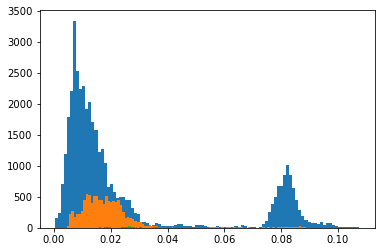

Train Epoch: 1	Loss: 0.173394	Train auc: 0.637966
Train Epoch: 2	Loss: 0.062679	Train auc: 0.583996
Train Epoch: 3	Loss: 0.046157	Train auc: 0.582236
Train Epoch: 4	Loss: 0.045243	Train auc: 0.579523
Train Epoch: 5	Loss: 0.044654	Train auc: 0.578137
Train Epoch: 6	Loss: 0.043736	Train auc: 0.574580
Train Epoch: 7	Loss: 0.041831	Train auc: 0.580155
Train Epoch: 8	Loss: 0.039110	Train auc: 0.587070
Train Epoch: 9	Loss: 0.037610	Train auc: 0.593379
Train Epoch: 10	Loss: 0.036504	Train auc: 0.608386
Train Epoch: 11	Loss: 0.034980	Train auc: 0.636122
Train Epoch: 12	Loss: 0.033109	Train auc: 0.670118
Train Epoch: 13	Loss: 0.031265	Train auc: 0.707572
Train Epoch: 14	Loss: 0.029610	Train auc: 0.732886
Train Epoch: 15	Loss: 0.028491	Train auc: 0.747211
Train Epoch: 16	Loss: 0.027757	Train auc: 0.758498
Train Epoch: 17	Loss: 0.027145	Train auc: 0.766460
Train Epoch: 18	Loss: 0.026585	Train auc: 0.775209
Train Epoch: 19	Loss: 0.025997	Train auc: 0.784018
Train Epoch: 20	Loss: 0.025388	Train auc

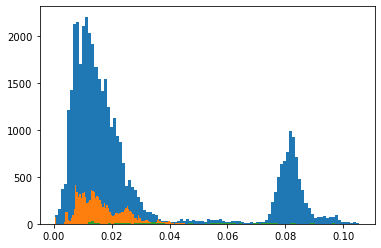

Train Epoch: 1	Loss: 0.275545	Train auc: 0.507942
Train Epoch: 2	Loss: 0.098412	Train auc: 0.604953
Train Epoch: 3	Loss: 0.043588	Train auc: 0.602633
Train Epoch: 4	Loss: 0.042148	Train auc: 0.602533
Train Epoch: 5	Loss: 0.041379	Train auc: 0.593299
Train Epoch: 6	Loss: 0.038465	Train auc: 0.598714
Train Epoch: 7	Loss: 0.035616	Train auc: 0.598069
Train Epoch: 8	Loss: 0.034659	Train auc: 0.601377
Train Epoch: 9	Loss: 0.033817	Train auc: 0.613256
Train Epoch: 10	Loss: 0.032736	Train auc: 0.626115
Train Epoch: 11	Loss: 0.031892	Train auc: 0.638451
Train Epoch: 12	Loss: 0.031033	Train auc: 0.654080
Train Epoch: 13	Loss: 0.030206	Train auc: 0.666183
Train Epoch: 14	Loss: 0.029641	Train auc: 0.672497
Train Epoch: 15	Loss: 0.029233	Train auc: 0.678426
Train Epoch: 16	Loss: 0.028839	Train auc: 0.692708
Train Epoch: 17	Loss: 0.028450	Train auc: 0.702682
Train Epoch: 18	Loss: 0.028007	Train auc: 0.711098
Train Epoch: 19	Loss: 0.027443	Train auc: 0.717331
Train Epoch: 20	Loss: 0.025903	Train auc

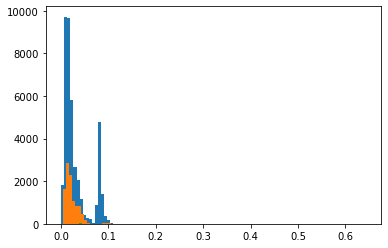

Train Epoch: 1	Loss: 0.251332	Train auc: 0.531310
Train Epoch: 2	Loss: 0.085072	Train auc: 0.739318
Train Epoch: 3	Loss: 0.040631	Train auc: 0.733664
Train Epoch: 4	Loss: 0.038327	Train auc: 0.733770
Train Epoch: 5	Loss: 0.037519	Train auc: 0.732611
Train Epoch: 6	Loss: 0.036728	Train auc: 0.728965
Train Epoch: 7	Loss: 0.035302	Train auc: 0.722649
Train Epoch: 8	Loss: 0.032694	Train auc: 0.712639
Train Epoch: 9	Loss: 0.030923	Train auc: 0.707572
Train Epoch: 10	Loss: 0.030316	Train auc: 0.714959
Train Epoch: 11	Loss: 0.029874	Train auc: 0.725311
Train Epoch: 12	Loss: 0.029260	Train auc: 0.732693
Train Epoch: 13	Loss: 0.028834	Train auc: 0.735032
Train Epoch: 14	Loss: 0.028543	Train auc: 0.737233
Train Epoch: 15	Loss: 0.028220	Train auc: 0.738820
Train Epoch: 16	Loss: 0.027691	Train auc: 0.739302
Train Epoch: 17	Loss: 0.026788	Train auc: 0.739763
Train Epoch: 18	Loss: 0.023838	Train auc: 0.739737
Train Epoch: 19	Loss: 0.000650	Train auc: 0.746608
Train Epoch: 20	Loss: -0.300452	Train au

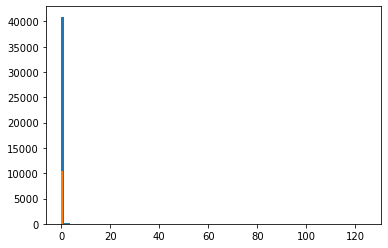

Train Epoch: 1	Loss: 0.196943	Train auc: 0.627727
Train Epoch: 2	Loss: 0.052282	Train auc: 0.636413
Train Epoch: 3	Loss: 0.038359	Train auc: 0.638997
Train Epoch: 4	Loss: 0.037102	Train auc: 0.641204
Train Epoch: 5	Loss: 0.034156	Train auc: 0.643224
Train Epoch: 6	Loss: 0.030970	Train auc: 0.642799
Train Epoch: 7	Loss: 0.028945	Train auc: 0.655469
Train Epoch: 8	Loss: 0.026992	Train auc: 0.674457
Train Epoch: 9	Loss: 0.024928	Train auc: 0.704746
Train Epoch: 10	Loss: 0.023124	Train auc: 0.730967
Train Epoch: 11	Loss: 0.021839	Train auc: 0.760737
Train Epoch: 12	Loss: 0.020484	Train auc: 0.797737
Train Epoch: 13	Loss: 0.019011	Train auc: 0.824779
Train Epoch: 14	Loss: 0.017852	Train auc: 0.844732
Train Epoch: 15	Loss: 0.017018	Train auc: 0.856536
Train Epoch: 16	Loss: 0.016350	Train auc: 0.872149
Train Epoch: 17	Loss: 0.015768	Train auc: 0.871736
Train Epoch: 18	Loss: 0.015244	Train auc: 0.881818
Train Epoch: 19	Loss: 0.014748	Train auc: 0.886587
Train Epoch: 20	Loss: 0.014296	Train auc

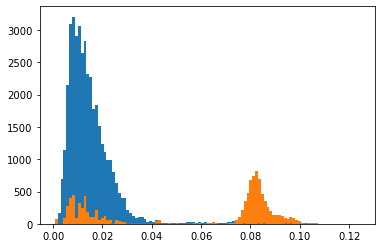

In [12]:
aead_aucs = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    aead = AEAD(300,512, 0.0001, 20, 'cpu', Adam, normal_only=False).fit(x_train_fold,  y_train_fold)
    y_pred_train_aead = aead.predict(x_train_fold)
    y_pred_train_aead  = y_pred_train_aead
    y_pred_train_aead_normal = y_pred_train_aead[y_train_fold==0]
    gmm = GaussianMixture(n_components=4)
    gmm.fit(y_pred_train_aead_normal.reshape(-1, 1))
    scores_train = gmm.score_samples(y_pred_train_aead_normal.reshape(len(y_pred_train_aead_normal), 1))
    threshold = np.percentile(scores_train, 80)
#     threshold = np.mean(y_pred_train_aead_normal)+np.std(y_pred_train_aead_normal)
    y_pred_aead_raw = aead.predict(x_val_fold)
    scores_val = gmm.score_samples(y_pred_aead_raw.reshape(-1, 1))
    val_auc = roc_auc_score(y_val_fold, y_pred_aead_raw)
    aead_aucs.append(val_auc)

#     fpr, tpr, thresholds = roc_curve(y_train_fold,y_pred_train_aead)
#     threshold_i = np.argmax(tpr - fpr)
    print(threshold)
    y_pred_aead = np.where(scores_val < threshold, 1, 0)
    print( scores_val)
    f1_score_aead = f1_score(y_val_fold, y_pred_aead, average='macro')
    print("Validation AUC", val_auc)
    print("Validation F1",f1_score_aead)
    plt.hist(y_pred_train_aead_normal, bins=100)
    plt.hist(y_pred_aead_raw[y_val_fold==0],  bins=100)
    plt.hist(y_pred_aead_raw[y_val_fold==1],  bins=100)

    plt.show()
    


_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Train Epoch: 1	Loss: 0.167006	Train auc: 0.591070
2.2801779950390673
[ 1.63516909  1.82810816 

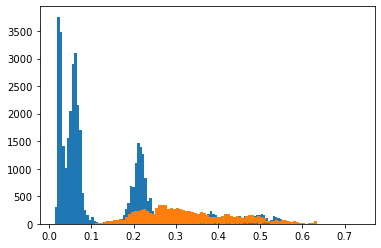

_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Train Epoch: 1	Loss: 0.140111	Train auc: 0.637104
2.666283288021845
[-0.74634175 -0.74648869 -

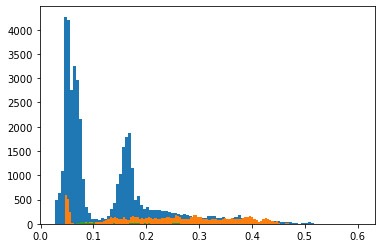

_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Train Epoch: 1	Loss: 0.212568	Train auc: 0.512837
1.9261926891245609
[1.71455152 1.71529631 1.

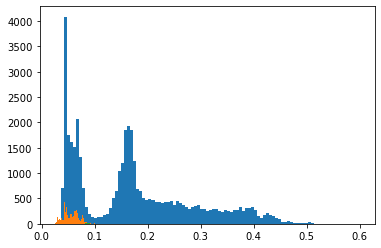

_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Train Epoch: 1	Loss: 0.232470	Train auc: 0.533025
1.890773000717345
[0.72180688 0.68877012 1.0

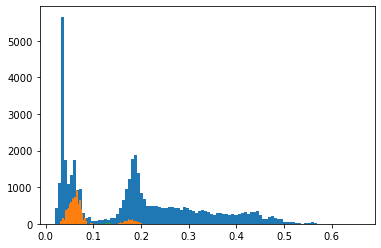

_CAEAD(
  (en_1): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_3): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (en_4): Conv1d(8, 4, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (de_1): Conv1d(4, 8, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_2): Conv1d(8, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (de_4): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
)
Train Epoch: 1	Loss: 0.241883	Train auc: 0.616026
2.0419825355599883
[-1.354902   -1.37037019 

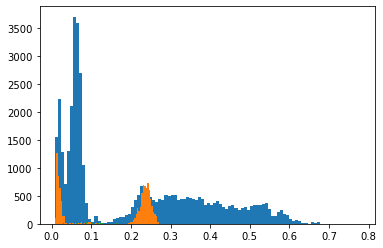

In [7]:
aead_aucs = []
for train_index, val_index in skf.split(x_train, y_train):
    x_train_fold = x_train[train_index]
    y_train_fold = y_train[train_index]
    
    x_val_fold = x_train[val_index]
    y_val_fold = y_train[val_index]
    
    aead = CAEAD(300,512, 0.0001, 20, 'cpu', Adam, normal_only=False).fit(x_train_fold,  y_train_fold)
    y_pred_train_aead = aead.predict(x_train_fold)
    y_pred_train_aead  = y_pred_train_aead
    y_pred_train_aead_normal = y_pred_train_aead[y_train_fold==0]
    gmm = GaussianMixture(n_components=4)
    gmm.fit(y_pred_train_aead_normal.reshape(-1, 1))
    scores_train = gmm.score_samples(y_pred_train_aead_normal.reshape(len(y_pred_train_aead_normal), 1))
    threshold = np.percentile(scores_train, 80)
#     threshold = np.mean(y_pred_train_aead_normal)+np.std(y_pred_train_aead_normal)
    y_pred_aead_raw = aead.predict(x_val_fold)
    scores_val = gmm.score_samples(y_pred_aead_raw.reshape(-1, 1))
    val_auc = roc_auc_score(y_val_fold, y_pred_aead_raw)
    aead_aucs.append(val_auc)

#     fpr, tpr, thresholds = roc_curve(y_train_fold,y_pred_train_aead)
#     threshold_i = np.argmax(tpr - fpr)
    print(threshold)
    y_pred_aead = np.where(scores_val > threshold, 1, 0)
    print( scores_val)
    f1_score_aead = f1_score(y_val_fold, y_pred_aead, average='macro')
    print("Validation AUC", val_auc)
    print("Validation F1",f1_score_aead)
    plt.hist(y_pred_train_aead_normal, bins=100)
    plt.hist(y_pred_aead_raw[y_val_fold==0],  bins=100)
    plt.hist(y_pred_aead_raw[y_val_fold==1],  bins=100)

    plt.show()

In [8]:
mean + std
1Validation AUC 0.6191607524381448
Validation F1 0.4900471277582076

2Validation AUC 0.7668440865966752
Validation F1 0.7804824561403507

3Validation AUC 0.9585138525884397
Validation F1 0.5569245690253449

4Validation AUC 0.7760579650066478
Validation F1 0.4541390395820775

5Validation AUC 0.5669661137764206
Validation F1 0.2778831327170103


mean 
1Validation AUC 0.6556487832864913
Validation F1 0.41829934661096263

2Validation AUC 0.7459972798506544
Validation F1 0.45086899030292055

3Validation AUC 0.9558852647419142
Validation F1 0.6455153500432657

4Validation AUC 0.8293288390989961
Validation F1 0.5542757673234727

5Validation AUC 0.5675759191947789
Validation F1 0.18268731378955166


Youdan indez + std on normal

Validation AUC 0.710109286855248
Validation F1 0.5778708367357263
]
Validation AUC 0.7521937010320048
Validation F1 0.7712795062670994

Validation AUC 0.9600471077318692
Validation F1 0.55445315827434

Validation AUC 0.8097037419935393
Validation F1 0.45251649957176676

Validation AUC 0.5705061448164643
Validation F1 0.2927271691710136

SyntaxError: invalid syntax (<ipython-input-8-cceaa3c7dcdb>, line 2)